# TopNN with Support Optimization
## Adding height penalty
## Full angle
## Numpy based FEA
## gradSV Calculation
## Fourier NN for both TO and SEG
## Super sampling support for SV calculation
## Passive elements
## CuPy for sparse iterative CUDA accelerated linear equation solving
## Reduced memory consuption with filtering NN input
## Used angle instead of direction vector
Created in 01/10/2022



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import time
import math as m
from matplotlib import pyplot as plt
from matplotlib import cm, colors
from IPython import display
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import linalg
import cupy as cp
import cupyx as cpx
from cupyx.scipy.sparse import linalg as linalg_g


c:\ProgramData\Anaconda3\envs\topopt\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
##################################### F E A ##################################
def lk_H8_np(nu):
    A = np.array([[32, 6, -8, 6, -6, 4, 3, -6, -10, 3, -3, -3, -4, -8], [-48, 0, 0, -24, 24, 0, 0, 0, 12, -12, 0, 12, 12, 12]],dtype = float)
    k = A.T@np.array([[1],[nu]])/144.0
    K1 = np.array([k[0],k[1],k[1],k[2],k[4],k[4],k[1],k[0],k[1],k[3],k[5],k[6],k[1],k[1],k[0],k[3],k[6],k[5],k[2],k[3],k[3],k[0],k[7],k[7],k[4],k[5],k[6],k[7],k[0],k[1],k[4],k[6],k[5],k[7],k[1],k[0]])
    K2 = np.array([k[8],k[7],k[11],k[5],k[3],k[6],k[7],k[8],k[11],k[4],k[2],k[4],k[9],k[9],k[12],k[6],k[3],k[5],k[5],k[4],k[10],k[8],k[1],k[9],k[3],k[2],k[4],k[1],k[8],k[11],k[10],k[3],k[5],k[11],k[9],k[12]])
    K3 = np.array([k[5],k[6],k[3],k[8],k[11],k[7],k[6],k[5],k[3],k[9],k[12],k[9],k[4],k[4],k[2],k[7],k[11],k[8],k[8],k[9],k[1],k[5],k[10],k[4],k[11],k[12],k[9],k[10],k[5],k[3],k[1],k[11],k[8],k[3],k[4],k[2]])
    K4 = np.array([k[13],k[10],k[10],k[12],k[9],k[9],k[10],k[13],k[10],k[11],k[8],k[7],k[10],k[10],k[13],k[11],k[7],k[8],k[12],k[11],k[11],k[13],k[6],k[6],k[9],k[8],k[7],k[6],k[13],k[10],k[9],k[7],k[8],k[6],k[10],k[13]])
    K5 = np.array([k[0],k[1],k[7],k[2],k[4],k[3],k[1],k[0],k[7],k[3],k[5],k[10],k[7],k[7],k[0],k[4],k[10],k[5],k[2],k[3],k[4],k[0],k[7],k[1],k[4],k[5],k[10],k[7],k[0],k[7],k[3],k[10],k[5],k[1],k[7],k[0]])
    K6 = np.array([k[13],k[10],k[6],k[12],k[9],k[11],k[10],k[13],k[6],k[11],k[8],k[1],k[6],k[6],k[13],k[9],k[1],k[8],k[12],k[11],k[9],k[13],k[6],k[10],k[9],k[8],k[1],k[6],k[13],k[6],k[11],k[1],k[8],k[10],k[6],k[13]])
    K1 = np.reshape(K1,[6,6])
    K2 = np.reshape(K2,[6,6])
    K3 = np.reshape(K3,[6,6])
    K4 = np.reshape(K4,[6,6])
    K5 = np.reshape(K5,[6,6])
    K6 = np.reshape(K6,[6,6])
    KE = np.concatenate([np.concatenate([K1, K2, K3, K4],1),np.concatenate([K2.T, K5, K6, K3.T],1),np.concatenate([K3.T, K6, K5.T, K2.T],1),np.concatenate([K4, K3, K2, K1],1)],0)/((nu+1)*(1-2*nu))
    return KE

# Parameters

seg = 2
index = 0
nelx = 30
nely = 30
nelz = 10
nelm = max(nelx,nely,nelz)
volfrac = 0.1
xPhys = tf.ones([nely,nelx,nelz])*volfrac

alpha_init = 1
alpha_max = 100
alpha_delta = 0.5
SV_init = 0.0
SV_max =  2.0
SV_delta = (SV_max - SV_init)/100.0
SV_coeff = SV_init
clip_threshold = 0.2
E0 = 1
Emin = 1e-6
nu = 0.3
nele = nelx*nely*nelz
penal_init = 2.0
penal_max = 4.0
penal_delta = 0.01

#Global variables used in custom gradient functions
penal = 2.0
total_epoch = 0

il = np.array([nelx,nelx,nelx],dtype = float)
jl = np.array([0,0,14],dtype = float)
kl = np.array([nelz, 0, nelz/2],dtype = float)
il_F = np.array([0,0,0.0],dtype = float)
jl_F = np.array([0.0,0.0,-1.0],dtype = float)
kl_F = np.array([0,0,0],dtype = float)
loadnid = kl*(nelx+1)*(nely+1) + il*(nely+1)+(nely+1-jl)
loaddofx = 3*loadnid-2
loaddofy = 3*loadnid-1
loaddofz = 3*loadnid

loaddofs = np.concatenate([loaddofx,loaddofy,loaddofz],0)
loaddofs = np.concatenate([np.expand_dims(loaddofs-1,1),np.zeros([9,1])],1)
loaddofv = np.concatenate([il_F,jl_F,kl_F],0)
nele = nelx*nely*nelz
ndof = 3*(nelx+1)*(nely+1)*(nelz+1)

F = coo_matrix((loaddofv, (loaddofs.astype(int)[:,0],loaddofs.astype(int)[:,1])), shape = [ndof,1])

#User defined support fixed dofs
iif, jf,kf = np.meshgrid(np.linspace(0.0,15,16),np.linspace(nely,nely,1),np.linspace(0,nelz,nelz+1))
fixednid = kf*(nelx+1)*(nely+1)+iif*(nely+1)+(nely+1-jf)
fixeddof = np.concatenate([3*fixednid,3*fixednid-1,3*fixednid-2],1)
U = np.zeros([ndof,1])


freedofs = np.setdiff1d(np.linspace(1.0,ndof,ndof), fixeddof.reshape([fixeddof.size]))
KE = lk_H8_np(nu)
nodegrd = np.transpose(np.reshape(np.linspace(1.0,(nely+1)*(nelx+1),(nely+1)*(nelx+1)),[nelx+1,nely+1]))
nodeids = np.reshape(np.transpose(nodegrd[0:nely,0:nelx]),[nely*nelx,1])
nodeidz = np.linspace(0.0,(nelz-1)*(nely+1)*(nelx+1),(nelz))
nodeids = nodeids*np.ones([1,nodeidz.shape[0]])+np.ones([nely*nelx,1])*nodeidz
edofVec = 3*np.reshape(np.transpose(nodeids),[np.size(nodeids),1])+1
edofMat = edofVec*np.ones([1,24]) + np.ones([nele,1])*np.array([0,1,2,3*nely+3,3*nely+4,3*nely+5,3*nely,3*nely+1,3*nely+2,-3,-2,-1,
                       3*(nely+1)*(nelx+1),3*(nely+1)*(nelx+1)+1,3*(nely+1)*(nelx+1)+2,3*(nely+1)*(nelx+1)+(3*nely+3),
                      3*(nely+1)*(nelx+1)+(3*nely+4),3*(nely+1)*(nelx+1)+(3*nely+5),3*(nely+1)*(nelx+1)+(3*nely),
                      3*(nely+1)*(nelx+1)+(3*nely+1),3*(nely+1)*(nelx+1)+(3*nely+2),3*(nely+1)*(nelx+1)-3,3*(nely+1)*(nelx+1)-2,
                      3*(nely+1)*(nelx+1)-1],dtype=float)
iK = np.reshape(np.repeat(edofMat,24*np.ones([nele],dtype=int),axis = 0),[24*24*nele])
jK = np.reshape(np.repeat(edofMat,24*np.ones([24],dtype=int),axis = 1),[24*24*nele])
freedofs = np.reshape(freedofs-1,[np.size(freedofs)]).astype(int)
F_f = F.tocsc()[freedofs]

U_prev = np.zeros(freedofs.shape)

#send necessary data into gpu
iK_g = cp.array(iK)
jK_g = cp.array(jK)
F_g = cpx.scipy.sparse.coo_matrix((cp.array(loaddofv), (cp.array(loaddofs.astype(int)[:,0]),cp.array(loaddofs.astype(int)[:,1]))), shape = (ndof,1))
F_f_g = F_g.tocsc()[freedofs]
KE_g = cp.array(KE)
freedofs_g = cp.array(freedofs)
U_prev_g = cp.zeros(freedofs.shape)

@tf.custom_gradient
def compliance_cp(x):
    global penal, U_prev_g
    xPhys = cp.array(x.numpy())
    start = time.time()
    sK = cp.reshape(KE_g,[-1,1])*(Emin + cp.power(cp.reshape(cp.transpose(xPhys),[1,-1]),penal)*(E0-Emin))
    sK = cp.reshape(cp.transpose(sK),[24*24*nele,1])
    K = cpx.scipy.sparse.coo_matrix((sK.reshape([-1]), ((jK_g-1).astype(int), (iK_g-1).astype(int))))
    K_f = K.tocsc()[freedofs] 
    K_f = K_f.transpose()[freedofs]
    f_size = freedofs.size
    K_fdiag = cp.asarray(K_f[cp.linspace(0,f_size-1,f_size,dtype=int),cp.linspace(0,f_size-1,f_size,dtype=int)])
    M =  cpx.scipy.sparse.spdiags(data = 1.0/K_fdiag,diags = 0, m = K_fdiag.size,n = K_fdiag.size)
    print ('GPU Assembly took {} sec'.format(time.time()-start))
    start = time.time()
    if nele>2000:
        U_f,_ = linalg_g.cg(K_f,F_f_g.toarray(),x0=U_prev_g,M=M,maxiter = 8000)
    else:
        U_f = linalg_g.spsolve(K_f,F_f_g.toarray())
    U_prev_g = U_f
    print ('GPU Linear solver took {} sec'.format(time.time()-start))
    U = cpx.scipy.sparse.coo_matrix((U_f, (freedofs_g,cp.zeros(freedofs.size,dtype = int)))).toarray()
    Ei = Emin + cp.power(xPhys,penal)*(E0-Emin)
    U_e = U[cp.reshape(edofMat-1,[-1]).astype(int)].reshape([edofMat.shape[0],edofMat.shape[1]])
    ce = cp.sum(U_e@KE_g*U_e,axis=1)
    Ei_t = cp.reshape(cp.transpose(Ei),[nelx*nely*nelz,1])
    c = (cp.sum(Ei_t*cp.expand_dims(ce,1))).get()
    
    def grad(dy):
        dc = -dy*penal*tf.pow(xPhys.get(),penal-1.0)*tf.convert_to_tensor(ce.get().reshape([nely,nelx,nelz],order='F'),dtype=tf.float32)
        #tf.print('dc:\n',dc)
        return tf.reshape(dc,[1,-1])
    return tf.convert_to_tensor(c,dtype=tf.float32),grad



def dl_linspace(nele):
    return np.linspace(-(nele-1)/(2*nelm),(nele-1)/(2*nelm),nele)
c_y, c_x, c_z=np.meshgrid(dl_linspace(nely),dl_linspace(nelx),dl_linspace(nelz),indexing='ij')
dlX = np.stack((c_y.reshape([-1]),c_x.reshape([-1]),c_z.reshape([-1])),axis = 1).reshape([-1,3])
dlX = tf.convert_to_tensor(dlX,dtype=tf.float32)*tf.constant([[-1.0,1.0,1.0]]) #coordinate input 
dlXm = tf.convert_to_tensor(dlX,dtype=tf.float32)*tf.constant([[1.0,1.0,-1.0]]) #Mirrored input coordinates

def dlinit_linspace(nele):
    return np.linspace(-(nele+2)/(2*nelm),(nele+2)/(2*nelm),nele)
c_y, c_x, c_z=np.meshgrid(dlinit_linspace(nely),dlinit_linspace(nelx),dlinit_linspace(nelz),indexing='ij')
dlinitX = np.stack((c_y.reshape([-1]),c_x.reshape([-1]),c_z.reshape([-1])),axis = 1).reshape([-1,3])
dlinitX = tf.convert_to_tensor(dlinitX,dtype=tf.float32)*tf.constant([[-1.0,1.0,1.0]]) #a slightly bigger input coordinate for pretraining segmentation field




def r3d_tf(angle): #calculates rotation matrix
    sx,sy,sz = (tf.constant(0.0,dtype=tf.float32),tf.math.sin(angle[0,0]), tf.math.sin(angle[0,1]))
    cx,cy,cz = (tf.constant(1.0,dtype=tf.float32),tf.math.cos(angle[0,0]), tf.math.cos(angle[0,1]))
    m00 = cy * cz
    m01 = (sx * sy * cz) - (cx * sz)
    m02 = (cx * sy * cz) + (sx * sz)
    m10 = cy * sz
    m11 = (sx * sy * sz) + (cx * cz)
    m12 = (cx * sy * sz) - (sx * cz)
    m20 = -sy
    m21 = sx * cy
    m22 = cx * cy
    matrix = tf.stack((m00, m10, m20,m01, m11, m21,m02, m12, m22),axis=-1)
    return tf.transpose(tf.reshape(matrix,[3,3]))
    #return tf.reshape(matrix,[3,3])

def r3d_tf2(angle):
     return r3d_tf(angle*tf.constant([[1.0,0.0]],dtype=tf.float32))@r3d_tf(angle*tf.constant([[0.0,1.0]],dtype=tf.float32),)

def euler2vec(rot): # converts euler angle to vector
    vecX = tf.math.sin(rot[:,1:2])
    vecZ = -tf.math.cos(0.5*m.pi - rot[:,0:1]) * tf.math.cos(rot[:,1:2])
    vecY = tf.math.sin(0.5*m.pi - rot[:,0:1]) * tf.math.cos(rot[:,1:2])
    return tf.concat([vecY,vecX,vecZ],axis = 1)

#Check FEA solver
c_0 = compliance_cp(tf.reshape(xPhys,[1,-1]))
tf.print('c0 is:',c_0)

GPU Assembly took 0.18936705589294434 sec
GPU Linear solver took 0.9219162464141846 sec
c0 is: 275.854156


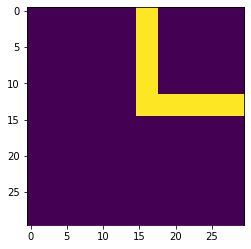

In [3]:
#Passive Elements 
passive = np.zeros([nely,nelx,nelz])
passive[12:15,15:30,:] = 1
passive[0:15,15:18,:] = 1
p_index = np.where(passive.reshape([-1]))[0]
dlX_passive = tf.convert_to_tensor(dlX.numpy()[p_index,:])
nele_passive = np.sum(passive)

plt.imshow(passive[:,:,0])

#Shell used for padding density gradient around the boundary
shell = np.ones([nely,nelx,nelz])
shell[1:nely-1,1:nelx-1,1:nelz-1] = 0
shell_index = np.where(shell.reshape([-1]))[0]
dlX_shell = tf.convert_to_tensor(dlinitX.numpy()[shell_index,:])

drho_shell = np.zeros((nely,nelx,nelz,3))
drho_shell[0,:,:,:] += np.array([-1.0,0,0])
drho_shell[-1,:,:,:] += np.array([1.0,0,0])
drho_shell[:,0,:,:] += np.array([0,1.0,0])
drho_shell[:,-1,:,:] += np.array([0,-1.0,0])
drho_shell[:,:,0,:] += np.array([0,0,-1.0])
drho_shell[0,:,-1,:] += np.array([0,0,1.0])
drho_shell = drho_shell.reshape([-1,3])
drho_shell = drho_shell / np.sqrt(np.sum(drho_shell**2.0,axis=1,keepdims=True)+0.0001 ) 

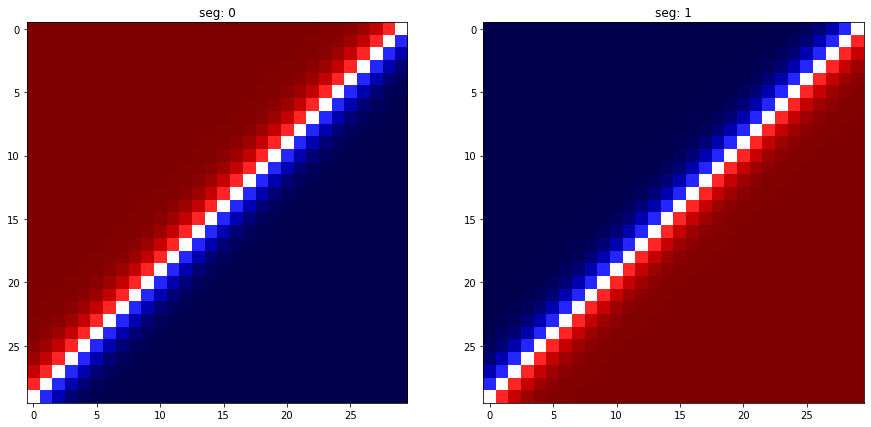

In [4]:
#################################Neural Network Setup##################################

init = tf.keras.initializers.Constant(0.0)

#topology network kernels
dlScale = 1.0
low_band = 0.01
high_band = 0.5


c_y, c_x, c_z=np.meshgrid(np.linspace([-high_band,low_band],[-low_band,high_band],8).reshape([-1]),
                                            np.linspace([-high_band,low_band],[-low_band,high_band],8).reshape([-1]),
                                            np.linspace([-high_band,low_band],[-low_band,high_band],6).reshape([-1]),indexing='ij')

dlInit = np.stack((c_y.reshape([-1]),c_x.reshape([-1]),c_z.reshape([-1])),axis = 0)

#segmentation network kernels
low_band = 0.0
high_band = 0.3

c_y, c_x, c_z=np.meshgrid(np.linspace([-high_band,low_band],[-low_band,high_band],8).reshape([-1]),
                                            np.linspace([-high_band,low_band],[-low_band,high_band],8).reshape([-1]),
                                            np.linspace([-high_band,low_band],[-low_band,high_band],6).reshape([-1]),indexing='ij')

dlsegInit = np.stack((c_y.reshape([-1]),c_x.reshape([-1]),c_z.reshape([-1])),axis = 0)

# Build Model
#topology model
c_init = tf.keras.initializers.Constant(0.0)
inputs = keras.Input(shape = [3])
NN = tf.keras.layers.experimental.RandomFourierFeatures(
    dlInit.shape[1], kernel_initializer='gaussian', scale=0.5,
    trainable=False)(inputs)
NN = layers.Dense(1,kernel_initializer=c_init)(NN)
outputs = tf.keras.layers.Activation('sigmoid')(NN)
to_model = keras.Model(inputs,outputs)
scale = np.sqrt(-(1/(30.0*dlScale))**2 / (2*np.log(0.04))  )
to_model.get_layer(index = 1).set_weights([np.array([scale]), dlInit, np.ones(dlInit.shape[1])])

#segmentation model
inputs = keras.Input(shape = [3])
NN = tf.keras.layers.experimental.RandomFourierFeatures(
    dlsegInit.shape[1], kernel_initializer='laplacian', scale=0.5,
    trainable=False)(inputs)
NN = layers.Dense(seg,kernel_initializer=c_init)(NN)
outputs = layers.Softmax()(NN)
seg_model = keras.Model(inputs,outputs)
seg_model.get_layer(index = 1).set_weights([np.array([scale]), dlsegInit, np.ones(dlsegInit.shape[1])])

#Angle calculation
initializer_a = tf.keras.initializers.Constant(0.0)
inputs_a = keras.Input(shape = [1])
NN = layers.Dense(2*seg,kernel_initializer=initializer_a)(inputs_a)
outputs_a = tf.keras.layers.Lambda(lambda x:tf.reshape(x,[-1,2]))(NN)
angle_model = keras.Model(inputs_a,outputs_a)

bias = np.zeros([2*seg])
angle_model.get_layer(index = 1).set_weights([np.array([[-0.0,0.0,0.0,0.0]])/57.295779, bias]) # X,Z axis rotation


#segmentation network initialization field
def init_linspace(nele,scale):
    return np.linspace(0,nele,int(nele*scale))
def DistanceInit():
    c_y, c_x, c_z = np.meshgrid(init_linspace(nely,dlScale),init_linspace(nelx,dlScale),init_linspace(nelz,dlScale),indexing='ij')
    dlX = np.stack((c_y.reshape([-1]),c_x.reshape([-1]),c_z.reshape([-1])),axis = 1)
    dlX = np.reshape(dlX,[-1,3])
    kernel = np.zeros([seg,3])
    kernel[0]=np.array([0,0,nelz/2])
    kernel[1]=np.array([nely,nelx,nelz/2])
    weights = np.zeros([nele,seg])
    for i in range(seg):#populating the weights based on inverse distance
        for j in range(nele):
            dist = np.sum(np.abs(dlX[j]-kernel[i]))+1.0
            weights[j,i] = 500.0/dist
    weights = np.exp(weights) / np.sum(np.exp(weights),axis = 1).reshape([-1,1])
    return weights

seg_init = tf.convert_to_tensor(DistanceInit(),dtype = tf.float32)
plt.figure(figsize=(15,15))
for i in range(seg):
    plt.subplot(1,seg,i+1)
    plt.title('seg: '+str(i))
    x_seg = x_seg = tf.reshape(seg_init[:,i], [nely,nelx,nelz])
    plt.imshow(tf.reduce_mean(x_seg,axis=2),vmin=0, vmax=1,cmap = 'seismic')
plt.show()



In [5]:
###############################Backpropagation############################################
log_sv = []
log_svh = []
log_compliance = []
log_vf = []
log_phi_x = []
log_phi_z = []
log_vec = []
log_phi = []
log_FDSV = []
log_seginit = []

to_optimizer1 = tf.keras.optimizers.SGD(0.02)
to_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.002)

seg_optimizer1 = tf.keras.optimizers.SGD(0.02)
seg_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.002)
angle_optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

#Overhang calculation
def height_loss1(index):
    angles = angle_model(tf.ones([1,1]),training=True)

    if(index==0):
        angle = angles[0:1,:]
    if(index==1):
        angle = angles[1:2,:]

    rot_coord = dlX@r3d_tf2(angle) #yxz

    with tf.GradientTape(persistent=True)  as g1:
        g1.watch(dlX)
        if(index==0):
            xPhys = (to_model(dlX)+to_model(dlX*tf.constant([[1.0,1.0,-1.0]])))*0.5*(seg_model(dlX)[:,0:1])
        if(index==1):
            xPhys = (to_model(dlX)+to_model(dlX*tf.constant([[1.0,1.0,-1.0]])))*0.5*(seg_model(dlX)[:,1:2])
        
    x_heavy = 1.0/(1+tf.exp(-2.0*10*(xPhys-0.3)))
    drho_dcoord = g1.gradient(xPhys,dlX)+tf.convert_to_tensor(drho_shell,dtype = tf.float32)*x_heavy* (nelm*1.0)
    dr_dcn = drho_dcoord / tf.sqrt(tf.reduce_sum(drho_dcoord**2.0,axis=1,keepdims=True)+0.01 )
    b = euler2vec(angle)
    overhang = 50.0*0.0174533 #overhang angle setting, 90:support everthing, 0: no support
    cos_alpha_n = tf.reshape(tf.tensordot(b,tf.transpose(dr_dcn),axes=1),[nely,nelx,nelz])
    cos_alpha = tf.reshape(tf.tensordot(b,tf.transpose(drho_dcoord),axes=1),[nely,nelx,nelz])
    cos_alpha_over = cos_alpha_n - tf.math.cos(overhang)
    h_cos_alpha = 1.0/(1+tf.exp(-2.0*10*(cos_alpha_over-0.0)))
    P_alpha = h_cos_alpha * cos_alpha

    x_heavy = 1.0/(1+tf.exp(-2.0*20*((to_model(dlX)+to_model(dlX*tf.constant([[1.0,1.0,-1.0]])))*0.5-0.3)))
    rotY = (rot_coord[:,0:1]-1.0)*x_heavy
    lowest = tf.math.reduce_min(rotY)+1.0
    height_offset = lowest
    P_height = tf.abs(tf.reshape(P_alpha, [-1]) * (rot_coord[:,0] - height_offset))

    sv = tf.reduce_sum(P_height) / (nelx*nelz*nely) * nelm
    return sv


def loss_sv_segs():
    angle_output = angle_model(tf.ones([1,1]),training=True)
    total_sv = 0.0
    for i in range(seg):
        total_sv += height_loss1(i)
    return total_sv


def model_loss(epoch):
    xPhys = (to_model(dlX)+to_model(dlXm))*0.5
    phi= angle_model(tf.ones([1,1]),training=True)
    loss_height = loss_sv_segs()
    global penal, SV_coeff
    penal = min(penal_init + penal_delta * epoch,penal_max)
    alpha = min(alpha_init + alpha_delta * epoch, alpha_max)
    c = compliance_cp(tf.reshape(xPhys,[nely,nelx,nelz]))
    if epoch > 150:
        SV_coeff = max(min(SV_coeff + SV_delta, SV_max),SV_init)
    else:
        SV_coeff = 0.0

    vf = tf.math.reduce_sum(xPhys)/(nele)

    passive_loss = tf.reduce_mean(tf.abs(to_model(dlX_passive) - tf.zeros([dlX_passive.shape[0],1])))
    loss = 1.0*c/c_0+alpha*(vf/volfrac-1.0)**2 + SV_coeff*(loss_height*1.0) + (alpha*5.0+20.0)*passive_loss

    tf.print('Epoch:',epoch,',Penal:',penal,',Alpha:',alpha,'Lambda SV:',SV_coeff)
    tf.print('Compliance:',c)
    tf.print('VF:',vf)
    tf.print('SVH% :',loss_height)
    tf.print('Current phi from NN:', phi,'[rad]')
    tf.print('Total Loss:',loss)
      
    vf = tf.math.reduce_mean(xPhys)
    log_sv.append(loss_height)
    log_svh.append(loss_height)
    log_compliance.append(c)
    log_vf.append(vf)
    log_phi.append(phi.numpy()*57.295779)
    return loss

def model_loss_angle(epoch):
    xPhys = to_model(dlX)
    phi= angle_model(tf.ones([1,1]),training=True)
    loss_height = loss_sv_segs()
    c = log_compliance[-1]
    SV_coeff = SV_max
    seg_diff = 0.0
    vf = tf.math.reduce_sum(xPhys)/(nele)
    loss = SV_coeff*(loss_height*1.0) 

    tf.print('Epoch:',epoch,',Penal:',penal,',Alpha:','Lambda SV:',SV_coeff)
    tf.print('Compliance:',c)
    tf.print('VF:',vf)
    tf.print('SVH% :',loss_height)
    tf.print('Current phi from NN:', phi,'[rad]')
    tf.print('Total Loss:',loss)
      
    vf = tf.math.reduce_mean(xPhys)
    log_sv.append(loss_height)
    log_svh.append(loss_height)
    log_compliance.append(c)
    log_vf.append(vf)
    log_phi.append(phi.numpy()*57.295779)
    return loss

def train_step(epoch):
    with tf.GradientTape(persistent=True) as model_tape:
        loss = model_loss(epoch)
    to_gradients = model_tape.gradient(loss,to_model.trainable_variables)
    to_gradients = [tf.clip_by_norm(g, 1.0) for g in to_gradients]
    if 100<epoch:
        to_optimizer2.apply_gradients(zip(to_gradients,to_model.trainable_variables)) #adam for fast converge
    else:
        to_optimizer1.apply_gradients(zip(to_gradients,to_model.trainable_variables)) #sgd for mobility
    angle_gradients = model_tape.gradient(loss,angle_model.trainable_variables)
    angle_optimizer.apply_gradients(zip(angle_gradients,angle_model.trainable_variables))
    seg_gradients = model_tape.gradient(loss,seg_model.trainable_variables)
    seg_gradients = [tf.clip_by_norm(g, 1.0) for g in seg_gradients]
    seg_optimizer2.apply_gradients(zip(seg_gradients,seg_model.trainable_variables))    

def train_step_angle(epoch):
    with tf.GradientTape(persistent=True) as model_tape:
        loss = model_loss_angle(epoch)
    angle_gradients = model_tape.gradient(loss,angle_model.trainable_variables)
    angle_optimizer.apply_gradients(zip(angle_gradients,angle_model.trainable_variables))
    
def train_step_seginit():
    with tf.GradientTape(persistent=True) as model_tape:
        loss = tf.reduce_mean(tf.abs(seg_model(dlinitX) - seg_init)) * 100.0
        tf.print('seg init loss:',loss)
        log_seginit.append(loss)
    seg_gradients = model_tape.gradient(loss,seg_model.trainable_variables)
    seg_optimizer1.apply_gradients(zip(seg_gradients,seg_model.trainable_variables))    

def train_step_passive():
    with tf.GradientTape(persistent=True) as model_tape:
        loss = tf.reduce_mean(tf.abs(to_model(dlX_passive) - tf.zeros([dlX_passive.shape[0],1]))) * 100.0
        tf.print('passive loss:',loss)
    to_gradients = model_tape.gradient(loss,to_model.trainable_variables)
    to_optimizer1.apply_gradients(zip(to_gradients,to_model.trainable_variables))  

def plot3d(xPhys): #xPhys in 3D shape
    cutoff = 0.3
    voxelarray = xPhys
    voxelarray[np.where(voxelarray<cutoff)] = 0
    voxelarray[np.where(voxelarray>cutoff)] = 1
    voxelarray.astype(bool)
    voxelarray = np.flip(voxelarray,axis=0)
    ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
    norm = colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)
    color = mapper.to_rgba(to_model(dlX).numpy()).reshape([nely,nelx,nelz,4])
    color = np.flip(color,axis=0)
    ax.voxels(voxelarray,facecolors=color, edgecolor='k')
    ax.view_init(20, -60,vertical_axis='x')
    ax.set_box_aspect(aspect = (nelx,nelz,nely))
    plt.show()

def display_seg():
    

    # combined vf plot
    cutoff = 0.3
    #plt.subplot(1,seg+1,1)
    #plot3d(to_model(dlX).numpy().reshape([nely,nelx,nelz]),False)
    xPhys = (to_model(dlX)+to_model(dlXm))/2.0
    to_output = tf.reshape(xPhys,[nely,nelx,nelz])
    fig = plt.figure(figsize=(15,15))
    voxelarray = to_output.numpy()
    voxelarray[np.where(voxelarray<cutoff)] = 0
    voxelarray[np.where(voxelarray>cutoff)] = 1
    voxelarray.astype(bool)
    voxelarray = np.flip(voxelarray,axis=0)
    ax = fig.add_subplot(1,seg+1,1,projection='3d')
    norm = colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)
    color = mapper.to_rgba(to_model(dlX).numpy()).reshape([nely,nelx,nelz,4])
    color = np.flip(color,axis=0)
    ax.voxels(voxelarray,facecolors=color, edgecolor='k')
    ax.view_init(20, -60,vertical_axis='x')
    ax.set_box_aspect(aspect = (nelx,nelz,nely))
    seg_x = tf.reshape(seg_model(dlX),[-1,seg])
    for i in range(seg):
        #plt.subplot(1,seg+1,i+2)
        x_seg = tf.reshape(seg_x[:,i], [nely,nelx,nelz])*to_output
        voxelarray = x_seg.numpy()
        voxelarray[np.where(voxelarray<cutoff)] = 0
        voxelarray[np.where(voxelarray>cutoff)] = 1
        voxelarray.astype(bool)
        voxelarray = np.flip(voxelarray,axis=0)
        ax = fig.add_subplot(1,seg+1,i+2, projection='3d')
        norm = colors.Normalize(vmin=0.0, vmax=1.0, clip=True)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.seismic)
        color = mapper.to_rgba(to_model(dlX).numpy()).reshape([nely,nelx,nelz,4])
        color = np.flip(color,axis=0)
        ax.voxels(voxelarray,facecolors=color, edgecolor='k')
        ax.view_init(20, -60,vertical_axis='x')
        ax.set_box_aspect(aspect = (nelx,nelz,nely)) 
    plt.show()

    for i in range(seg):
        plt.subplot(1,seg+1,i+2)
        plt.title('seg: '+str(i))
        x_seg = tf.reshape(seg_x[:,i], [nely,nelx,nelz])*to_output
        plt.imshow(tf.reduce_mean(x_seg,axis=2),vmin=0, vmax=1,cmap = 'seismic')
    plt.colorbar()
    plt.show()

def plot_params():
    plt.figure(figsize=(20,5))
    #SV log 
    plt.subplot(1,seg+3,1)
    plt.title('SV vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('SV')
    plt.plot(log_sv)

    #VF log 
    plt.subplot(1,seg+3,2)
    plt.title('Volume Fraction vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('VF')
    plt.plot(log_vf)

    #Compliance log 
    plt.subplot(1,seg+3,3)
    plt.title('Compliance vs Iteration')
    plt.xlabel('iteration')
    plt.ylabel('Compliance')
    plt.plot(log_compliance)

    log_phi_np = np.array(log_phi)
    for i in range(seg):
        plt.subplot(1,seg+3,i+4)
        plt.title('XZ Angle vs Iteration, seg:'+str(i))
        plt.xlabel('iteration')
        plt.ylabel('Deg [deg]')
        plt.plot((log_phi_np[:,i,0]+180)%360-180,label='x angle')
        plt.plot((log_phi_np[:,i,1]+180)%360-180,label='z angle')
        plt.legend()

    plt.show()    

def fit(epochs):
    global total_epoch
    for epoch in range(epochs):
        start = time.time()
        if epoch%2==1:
            display.clear_output(wait=True)
            plot_params()
        total_epoch = total_epoch + 1
        print("Epoch: ", total_epoch)
        to_output = tf.reshape(tf.reduce_sum(to_model(dlX),axis = 1),[nely,nelx,nelz])
        seg_x = seg_model(dlX)
        x = to_output
        display_seg()
        epsilon_g = tf.reduce_mean(tf.cast(tf.math.logical_and(x>0.1, x<0.9),tf.float32))
        train_step(total_epoch)
        to_output = tf.reshape(tf.reduce_sum(to_model(dlX),axis = 1),[nely,nelx,nelz])
        x_new = to_output
        seg_new = seg_model(dlX)
        tf.print('ch_to:',tf.reduce_sum(tf.abs(x_new-x)))
        tf.print('ch_seg:',tf.reduce_sum(tf.abs(seg_x-seg_new)))
        epsilon_g = tf.reduce_mean(tf.cast(tf.math.logical_and(x_new>0.1, x_new<0.9),tf.float32))
        tf.print('epsilon_g is:',epsilon_g)
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

def fit_angle(epochs):
    global total_epoch
    for epoch in range(epochs):
        start = time.time()
        if epoch%2==1:
            display.clear_output(wait=True)
            plot_params()
        total_epoch = total_epoch
        print("Epoch: ", total_epoch)

        to_output = tf.reshape(tf.reduce_sum(to_model(dlX),axis = 1),[nely,nelx,nelz])
        seg_x = seg_model(dlX)
        x = to_output

        display_seg()
        
        epsilon_g = tf.reduce_mean(tf.cast(tf.math.logical_and(x>0.1, x<0.9),tf.float32))
        
        train_step_angle(total_epoch)
        to_output = tf.reshape(tf.reduce_sum(to_model(dlX),axis = 1),[nely,nelx,nelz])
        x_new = to_output
        seg_new = seg_model(dlX)
        tf.print('ch_to:',tf.reduce_sum(tf.abs(x_new-x)))
        tf.print('ch_seg:',tf.reduce_sum(tf.abs(seg_x-seg_new)))
        epsilon_g = tf.reduce_mean(tf.cast(tf.math.logical_and(x_new>0.1, x_new<0.9),tf.float32))
        tf.print('epsilon_g is:',epsilon_g)
        
        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

def fit_seg_init(epochs):
    for epoch in range(epochs):
        print("Epoch: ", epoch)
        if epoch%2==1:
            display.clear_output(wait=True)
        train_step_seginit()
        plt.title('Seginit loss vs Iteration')
        plt.xlabel('iteration')
        plt.ylabel('L1 loss')
        plt.plot(log_seginit)
        plt.show()

seg init loss: 3.20017481


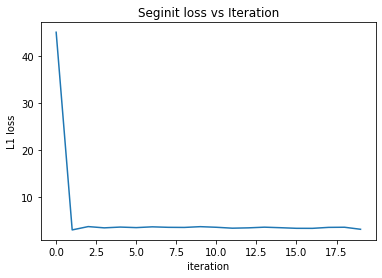

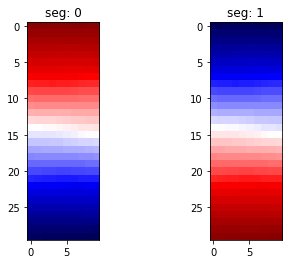

In [6]:
fit_seg_init(20)

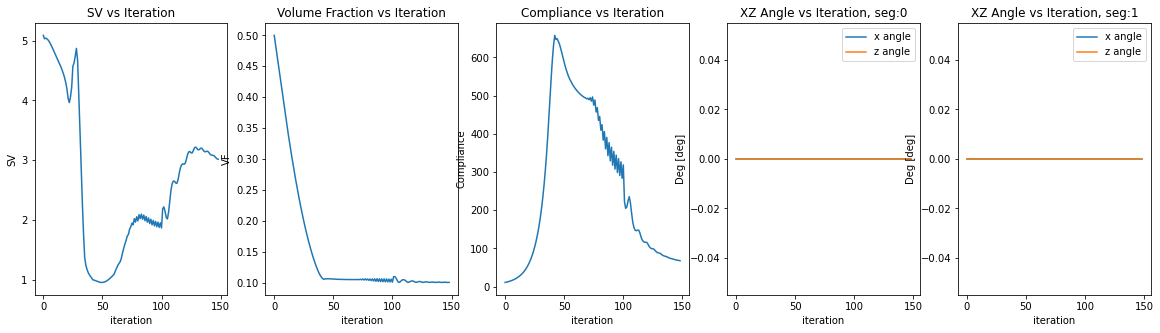

Epoch:  150


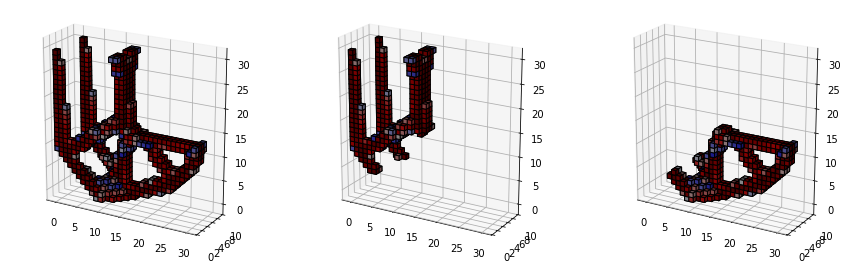

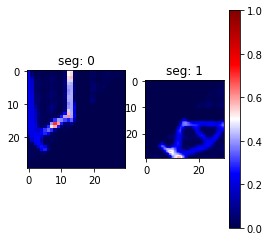

GPU Assembly took 0.1604630947113037 sec
GPU Linear solver took 0.8406929969787598 sec
Epoch: 150 ,Penal: 3.5 ,Alpha: 76.0 Lambda SV: 0.0
Compliance: 67.0633545
VF: 0.100459576
SVH% : 3.0144105
Current phi from NN: [[0 0]
 [0 0]] [rad]
Total Loss: 0.270094275
ch_to: 6.19716501
ch_seg: 0
epsilon_g is: 0.108888887
Time taken for epoch 150 is 3.4275033473968506 sec



In [7]:
fit(150)

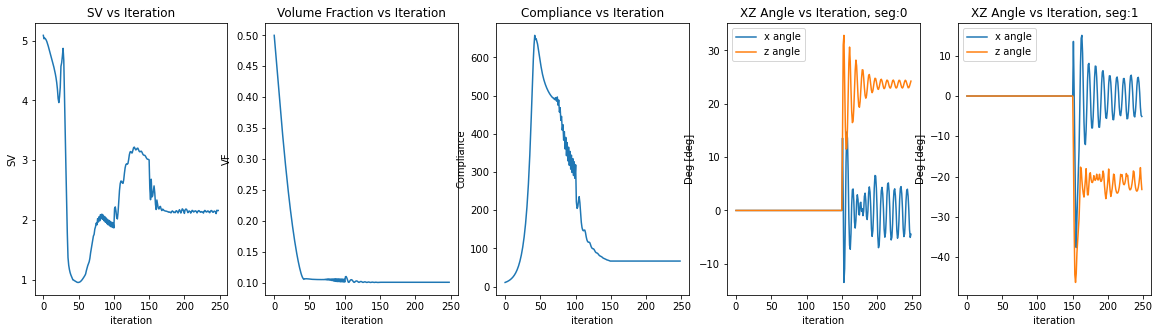

Epoch:  150


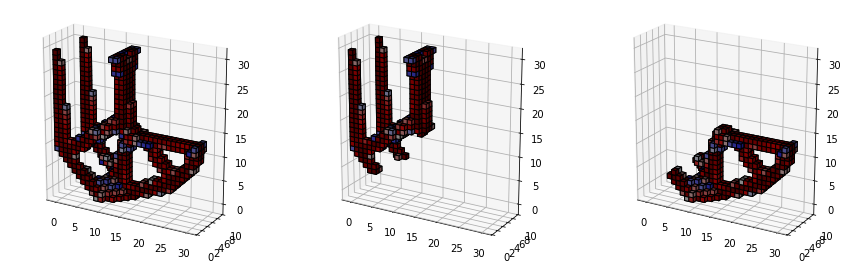

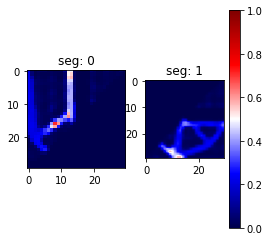

Epoch: 150 ,Penal: 3.5 ,Alpha: Lambda SV: 2.0
Compliance: 67.0633545
VF: 0.100473814
SVH% : 2.14246416
Current phi from NN: [[-0.0364738889 0.425668448]
 [-0.0651465356 -0.432319224]] [rad]
Total Loss: 4.28492832
ch_to: 0
ch_seg: 0
epsilon_g is: 0.108888887
Time taken for epoch 100 is 2.418213367462158 sec



In [8]:
fit_angle(100)

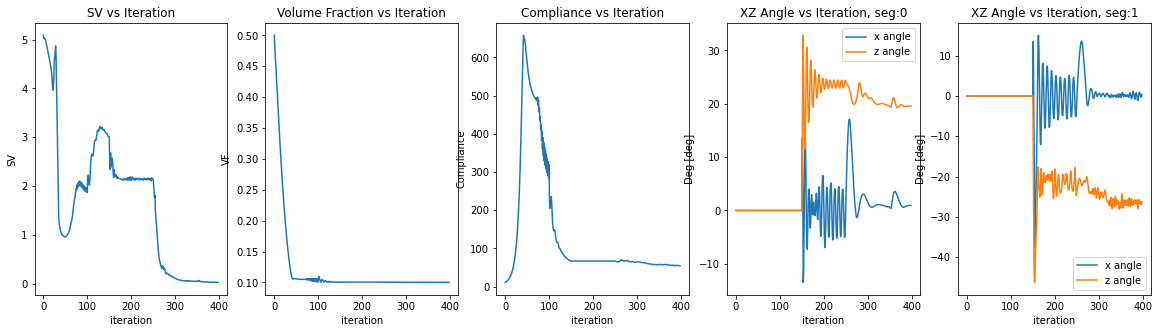

Epoch:  300


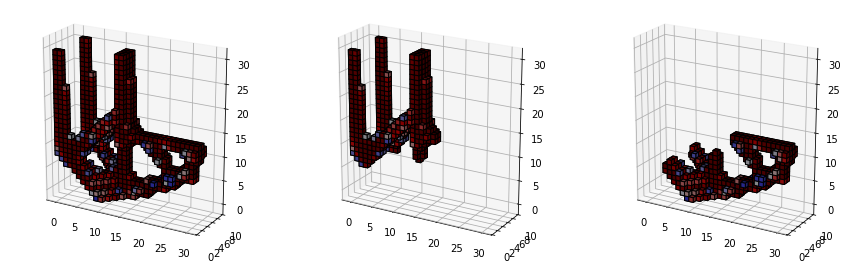

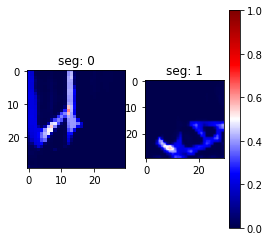

GPU Assembly took 0.15149474143981934 sec
GPU Linear solver took 0.7504873275756836 sec
Epoch: 300 ,Penal: 4.0 ,Alpha: 100 Lambda SV: 2.0
Compliance: 54.303688
VF: 0.100223422
SVH% : 0.0242819786
Current phi from NN: [[0.016148027 0.341307]
 [0.00888890773 -0.468290687]] [rad]
Total Loss: 0.252209604
ch_to: 4.29519892
ch_seg: 3.40076041
epsilon_g is: 0.0635555536
Time taken for epoch 150 is 3.3647451400756836 sec



In [9]:
fit(150)